Day 38 : 21/03/15
- https://www.kaggle.com/c/mercari-price-suggestion-challenge
- https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling

# Mercari Interactive EDA + Topic Modeling

이것은 matplotlib을 사용한 Mercari Price Suggestion Challenge에 대한 초기 EDA다. bokeh와 Plot.ly는 예쁜 대화형 플롯과 대시보드를 만드는 시각화 도구다. 이 대회는 Mercari가 개최했고, Mercari는 상품 정보가 주어지면, 판매자에게 제시해야하는 정확한 가격을 예측하는 것을 주요 목표로 하는 일본 최대 커뮤니티 기반 쇼핑 앱이다.

클러스터링 주제에 대한 문서와 기계학습 기술(K-means와 LDA)의 전처리에 대한 지침을 통해 커널을 두 파트로 나눈다.
1. EDA (Explanatory Data Analysis)
2. Text Processing
- 2.1. Tokenizing and tf-idf algorithm
- 2.2. K-means Clustering
- 2.3. Latent Dirichlet Allocation(LDA) / Topic Modelling

In [1]:
### Latent Dirichlet Allocation (LDA)
### 토픽 모델링의 대표적 알고리즘
### LDA는 문서들은 토픽들의 혼합으로 구성되어 있으며, 토픽들은 확률 분포에 기반해 단어들을 생성한다고 가정. 
### 데이터가 주어지면, LDA는 문서가 생성되던 과정을 역추적.

In [90]:
import pandas as pd
import numpy as np
import re
import pickle
import string
import nltk
import warnings
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import factor_cmap


%matplotlib inline
sns.set(style='white')
warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)
logging.getLogger('lda').setLevel(logging.WARNING)

In [5]:
train = pd.read_csv('../input/train.tsv', sep='\t')
test = pd.read_csv('../input/test.tsv', sep='\t')

In [6]:
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [7]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [8]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## Target Variable : Price

다음 표준 점검은 목표 변수(대응 변수)이고, 이 경우 Mercari의 시장 판매자에게 제안할 가격이다. training에서 모든 상품의 가격 중간값은 약 $267지만, $100 이상과 최대값 $2,009인 일부 극단값의 존재가 주어져, 변수의 분포는 왼쪽으로 크게 치우쳐져있다. 따라서 가격에 로그 변환을 한다(0과 음수 피하기 위해 변환 전 값에 +1 추가)

In [9]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [13]:
log_price = train['price'].apply(lambda x: np.log(x+1))

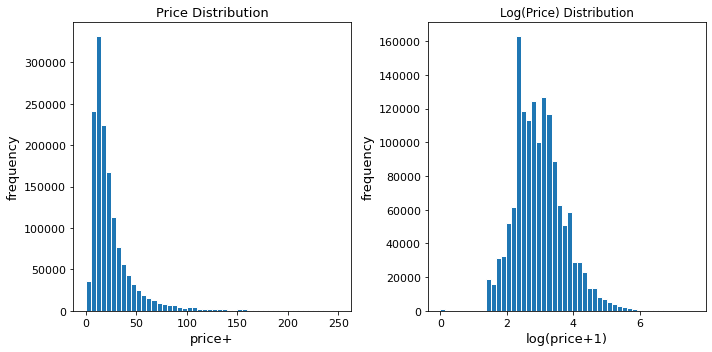

In [67]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(train['price'], bins=50, edgecolor='white', range=[0,250])
plt.xlabel('price+', fontsize=13)
plt.ylabel('frequency', fontsize=13)
plt.tick_params(labelsize=11)
plt.title('Price Distribution', fontsize=13)

plt.subplot(1,2,2)
plt.hist(np.log(train['price']+1), bins=50, edgecolor='white')
plt.xlabel('log(price+1)', fontsize=13)
plt.ylabel('frequency', fontsize=13)
plt.tick_params(labelsize=11)
plt.title('Log(Price) Distribution')

plt.tight_layout()
plt.show()

## Shipping

상품의 배송비가 절반 이상인 판매자와 구매자 사이에 배송비 부담이 분산되어 판매자가 부담(55%)하는 것으로 나타났다. 또한, 배송비를 지불해야하는 이용자들이 지불하는 평균 가격은 추가 배송비가 없는 가격보다 낮다. 이는 판매자들이 추가 배송을 보상하기 위해 가격이 더 낮아야한다는 인식과 일치한다.

In [70]:
train.shipping.value_counts() / len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

In [72]:
prc_shipBySeller = train.loc[train.shipping==1, 'price']
prc_shipByBuyer = train.loc[train.shipping==0, 'price']

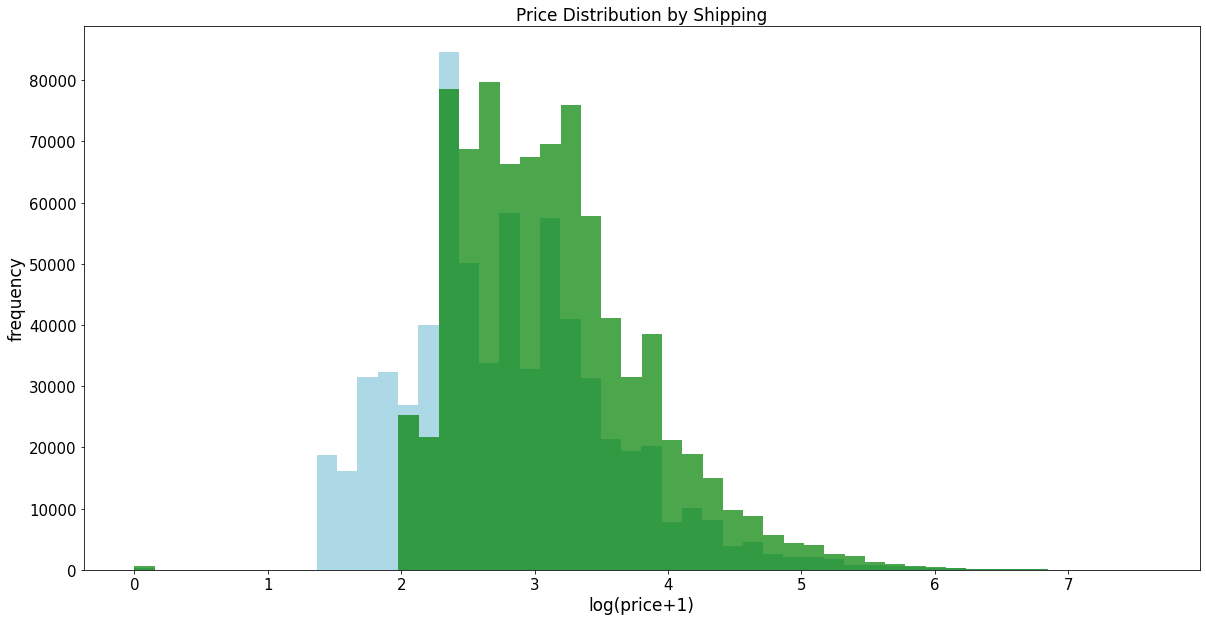

In [77]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1), color='lightblue', alpha=1.0, bins=50,
       label = 'Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='green', alpha=0.7, bins=50,
       label = 'Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

## Item Category

약 1,287개의 고유 범주가 있지만, 각 범주 중 항상 주요/일반 범주를 먼저 보고, 그 다음 두 개의 특정 하위 범주(예:뷰티/메이크업/얼굴/립)를 추가로 확인한다. 또한 범주 레이블이 없는 항목도 약 6,327개다. 범주를 세 개의 다른 열로 나눠보자. 나중에 이 정보가 판매자의 괁머에서 실제로 매우 중요하며 brand_name 열의 누락 정보를 처리하는 방법이 모델의 예측에 영향을 미칠 것을 알게 될 것이다.

In [78]:
# Top 5 Raw Categories
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [79]:
# missing categories
print('There are %d items that do not have a label.' %train['category_name'].isnull().sum())

There are 6327 items that do not have a label.


In [80]:
def split_cat(text):
    try : return text.split('/')
    except : return ('No Label','No Label','No Label')

In [81]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(
    *train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [82]:
print('There are %d unique first sub-categories.' %train['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [83]:
print('There are %d unique second sub-cateogires.' %train['subcat_2'].nunique())

There are 871 unique second sub-cateogires.


전체적으로, 7개의 주요 범주(첫 하위범주 114개, 두번째 하위범주 871개)가 있다. women's와 beauty 상품은 가장 인기있는 범주 두 가지이고(관측치가 50% 이상), kids와 electronics가 그 뒤를 잇는다.

In [84]:
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
pct = [('%.2f' %(v*100)) + '%' for v in (y/len(train))]

In [91]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title='Number of Items by Main Category',
             yaxis=dict(title='Counts'), xaxis=dict(title='Category'))
fig = dict(data=[trace1], layout=layout)
py.iplot(fig)